In [28]:
import os
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image

from sentinelhub import (
    SHConfig,
    SentinelHubRequest,
    DataCollection,
    MimeType,
    CRS,
    BBox
)

CLIENT_ID = 'Get your own API :)'
CLIENT_SECRET = 'Get your own API :)'

DATASET_FILE = "labeled_deforestation_dataset.csv"
IMAGE_DIR = "satellite_images_ndvi" 
IMAGE_SIZE = (224, 224)
MODEL_SAVE_PATH = "deforestation_model_custom_ndvi.h5" 

config = SHConfig()
if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
else:
    print("Warning: Sentinel Hub credentials are not set.")

def fetch_and_save_ndvi_image(bbox_coords, image_path):
    if not config.sh_client_id or not config.sh_client_secret:
        return False
        
    try:
        bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84)
        evalscript_ndvi = """
            //VERSION=3
            function setup() {
                return {
                    input: ["B04", "B08"], // Red and Near-Infrared bands
                    output: { bands: 1, sampleType: "FLOAT32" } // Single band output
                };
            }
            function evaluatePixel(sample) {
                let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04 + 1e-6);
                return [ndvi];
            }
        """
        request = SentinelHubRequest(
            evalscript=evalscript_ndvi,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A,
                    time_interval=("2023-01-01", "2023-12-31"),
                    mosaicking_order='leastCC'
                )
            ],
            responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
            bbox=bbox,
            size=IMAGE_SIZE,
            config=config
        )
        image_data = request.get_data()[0]
        
        normalized_data = ((np.nan_to_num(image_data, nan=0.0) + 1) / 2 * 255).astype(np.uint8)
        img = Image.fromarray(normalized_data)
        img.save(image_path)
        return True
    except Exception as e:
        print(f"Could not fetch NDVI image for bbox {bbox_coords}. Error: {e}")
        return False

def prepare_dataset():
    print("--- Starting Dataset Preparation (NDVI) ---")
    os.makedirs(IMAGE_DIR, exist_ok=True)
    image_paths, labels = [], []
    with open(DATASET_FILE, 'r') as f:
        reader = csv.DictReader(f)
        for i, row in enumerate(reader):
            bbox = [float(row['minx']), float(row['miny']), float(row['maxx']), float(row['maxy'])]
            is_affected = row['isAffected'].lower() == 'true'
            image_filename = f"image_{i}_{'affected' if is_affected else 'unaffected'}.png"
            image_path = os.path.join(IMAGE_DIR, image_filename)
            if not os.path.exists(image_path):
                print(f"Fetching NDVI image {i+1} for bbox: {bbox}")
                fetch_and_save_ndvi_image(bbox, image_path)
            if os.path.exists(image_path):
                image_paths.append(image_path)
                labels.append(1 if is_affected else 0)
    print(f"--- Dataset preparation complete. Found {len(image_paths)} images. ---")
    return image_paths, np.array(labels)

def load_images(image_paths):
    print("--- Loading NDVI Images ---")
    images = []
    for path in image_paths:
        img = Image.open(path).convert('L') 
        img_array = np.array(img) / 255.0 
        images.append(np.expand_dims(img_array, axis=-1))
    return np.array(images)

def build_custom_cnn():
    print("--- Building Custom CNN for NDVI ---")
    
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    return model

if __name__ == "__main__":
    all_image_paths, all_labels = prepare_dataset()
    
    if len(all_image_paths) > 20:
        all_images = load_images(all_image_paths)
        
        X_train, X_val, y_train, y_val = train_test_split(
            all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
        )
        
        model = build_custom_cnn()
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        
        print("\n--- Training Custom NDVI Model ---")
        model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
        
        history = model.fit(
            X_train, y_train,
            epochs=50,
            validation_data=(X_val, y_val),
            batch_size=32,
            callbacks=[early_stopping]
        )
        
        print(f"\n--- Training complete. Saving model to '{MODEL_SAVE_PATH}' ---")
        model.save(MODEL_SAVE_PATH)
        print("✅ Model saved successfully.")
    else:
        print("\nTraining skipped: Not enough images were successfully downloaded.")


--- Starting Dataset Preparation (NDVI) ---
Fetching NDVI image 1 for bbox: [4.062796841044246, 7.954945986835284, 4.108443402295876, 8.000030947657109]
Fetching NDVI image 2 for bbox: [71.76870503534485, 35.83705047902278, 71.8107870929598, 35.88862961614426]
Fetching NDVI image 4 for bbox: [-49.968527060098126, -5.845954930433689, -49.86852706009813, -5.745954930433689]
Fetching NDVI image 5 for bbox: [-89.00705244956704, 17.130665327843754, -88.90705244956705, 17.230665327843756]
Fetching NDVI image 6 for bbox: [24.72679766536147, 6.334398670629673, 24.82679766536147, 6.4343986706296725]
Fetching NDVI image 7 for bbox: [12.980313140733625, 0.7220988315985832, 13.080313140733626, 0.8220988315985833]
Fetching NDVI image 8 for bbox: [-89.09414071649562, 20.868089489105085, -88.99414071649562, 20.968089489105086]
Fetching NDVI image 12 for bbox: [-61.647183279450346, -27.567840989890417, -61.54718327945035, -27.467840989890416]
Fetching NDVI image 13 for bbox: [45.525540971516364, 38.45

/Users/akshat/Desktop/Stuff/AI_CarbonEye/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Training Custom NDVI Model ---
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 749ms/step - accuracy: 0.8494 - loss: 1.9057 - val_accuracy: 0.5000 - val_loss: 7.1732
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 782ms/step - accuracy: 0.8925 - loss: 0.6258 - val_accuracy: 0.5000 - val_loss: 7.5636
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 692ms/step - accuracy: 0.9131 - loss: 0.3519 - val_accuracy: 0.5000 - val_loss: 11.4882
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 722ms/step - accuracy: 0.9369 - loss: 0.2811 - val_accuracy: 0.5000 - val_loss: 14.2285
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 910ms/step - accuracy: 0.9513 - loss: 0.1600 - val_accuracy: 0.5000 - val_loss: 11.9929
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 806ms/step - accuracy: 0.9644 - loss: 0.1141 - val_accuracy: 0.5000 - val_loss: 14.8252
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 795ms/step - accuracy: 0.9775 - loss: 0.0741 - val_accuracy: 0.5050 - val_loss: 10.2480
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 665ms/step - a


--- Training complete. Saving model to 'deforestation_model_custom_ndvi.h5' ---
✅ Model saved successfully.


In [29]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from sentinelhub import SHConfig, SentinelHubRequest, DataCollection, MimeType, CRS, BBox

CLIENT_ID = 'Get your own API :)'
CLIENT_SECRET = 'Get your own API :)'

MODEL_PATH = "deforestation_model_custom_ndvi.h5" 
IMAGE_SIZE = (224, 224)

config = SHConfig()
if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
else:
    print("Warning: Sentinel Hub credentials are not set.")

def fetch_ndvi_image_for_prediction(bbox_coords):
    if not config.sh_client_id or not config.sh_client_secret:
        return None
        
    try:
        bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84)
        evalscript_ndvi = """
            //VERSION=3
            function setup() {
                return {
                    input: ["B04", "B08"],
                    output: { bands: 1, sampleType: "FLOAT32" }
                };
            }
            function evaluatePixel(sample) {
                let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04 + 1e-6);
                return [ndvi];
            }
        """
        request = SentinelHubRequest(
            evalscript=evalscript_ndvi,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A,
                    time_interval=("2023-01-01", "2023-12-31"),
                    mosaicking_order='leastCC'
                )
            ],
            responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
            bbox=bbox,
            size=IMAGE_SIZE,
            config=config
        )
        image_data = request.get_data()[0]
        return image_data
    except Exception as e:
        print(f"Could not fetch NDVI image for bbox {bbox_coords}. Error: {e}")
        return None

def predict_on_bbox(model, bbox, location_name):
    print(f"\n--- Testing: {location_name} ---")
    image_array = fetch_ndvi_image_for_prediction(bbox)
    
    if image_array is not None:
        cleaned_array = np.nan_to_num(image_array, nan=0.0)
        normalized_array = (cleaned_array + 1) / 2.0 
        image_with_channel = np.expand_dims(normalized_array, axis=-1)
        image_batch = np.expand_dims(image_with_channel, axis=0)
        prediction = model.predict(image_batch, verbose=0)[0][0]
        
        confidence = prediction * 100
        if confidence > 50:
            print(f"✅ Prediction: Deforestation DETECTED (Confidence: {confidence:.2f}%)")
        else:
            print(f"🌲 Prediction: NO Deforestation Detected (Confidence: {100-confidence:.2f}%)")
    else:
        print("-> Could not make a prediction for this location.")
if __name__ == "__main__":
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model file not found at '{MODEL_PATH}'.")
    else:
        print(f"Loading model from '{MODEL_PATH}'...")
        loaded_model = tf.keras.models.load_model(MODEL_PATH)
        
        test_locations = {
            "Brazil Deforestation": [-63.9, -9.0, -63.4, -8.5],
            "Yosemite National Park": [-119.8, 37.5, -119.3, 38.0],
            "Tokyo, Japan (Urban)": [139.6, 35.5, 140.1, 36.0],
            "Indonesia Palm Oil Plantation": [101.3, 1.5, 101.8, 2.0],
            "Sahara Desert": [10.0, 25.0, 10.5, 25.5],
        }
        
        for name, bbox in test_locations.items():
            predict_on_bbox(loaded_model, bbox, name)


Loading model from 'deforestation_model_custom_ndvi.h5'...



--- Testing: Brazil Deforestation ---
✅ Prediction: Deforestation DETECTED (Confidence: 98.37%)

--- Testing: Yosemite National Park ---
🌲 Prediction: NO Deforestation Detected (Confidence: 98.39%)

--- Testing: Tokyo, Japan (Urban) ---
🌲 Prediction: NO Deforestation Detected (Confidence: 100.00%)

--- Testing: Indonesia Palm Oil Plantation ---
🌲 Prediction: NO Deforestation Detected (Confidence: 99.99%)

--- Testing: Sahara Desert ---
🌲 Prediction: NO Deforestation Detected (Confidence: 100.00%)


In [26]:
import requests
import zipfile
import geopandas as gpd
import io
import os
import shutil
import random
import numpy as np
from contextlib import closing
from shapely.geometry import Point

def get_affected_regions(url, output_file, num_records=1000):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
    }
    
    print(f"Attempting to download deforestation fronts data from: {url}")
    temp_dir = "temp_deforested_data"

    try:
        response = requests.get(url, headers=headers, stream=True, timeout=300)
        response.raise_for_status()
        print("✅ Download successful. Extracting data...")

        with closing(response), zipfile.ZipFile(io.BytesIO(response.content)) as z:
            os.makedirs(temp_dir, exist_ok=True)
            z.extractall(temp_dir)
            
            shapefile_path = None
            for root, dirs, files in os.walk(temp_dir):
                for file in files:
                    if file.endswith('.shp'):
                        shapefile_path = os.path.join(root, file)
                        break
                if shapefile_path:
                    break
            
            if not shapefile_path:
                raise FileNotFoundError("No .shp file found in the zip archive.")
            
            print(f"Shapefile found: {shapefile_path}")
            gdf = gpd.read_file(shapefile_path)

            print(f"Shapefile loaded with {len(gdf)} deforestation front polygons.")
            print(f"Generating {num_records} random points within these fronts...")
            
            generated_bboxes = []
            polygons = gdf.geometry.tolist()
            
            while len(generated_bboxes) < num_records:
                polygon = random.choice(polygons)
                minx, miny, maxx, maxy = polygon.bounds
                pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
                if polygon.contains(pnt):
                    bbox = [pnt.x - 0.05, pnt.y - 0.05, pnt.x + 0.05, pnt.y + 0.05]
                    generated_bboxes.append(bbox)

            print(f"Successfully generated {len(generated_bboxes)} points. Saving to file...")
            
            with open(output_file, 'w') as f:
                f.write("minx,miny,maxx,maxy\n")
                for bbox in generated_bboxes:
                    line = f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}\n"
                    f.write(line)
            
            print(f"✅ Successfully saved {len(generated_bboxes)} affected region bounding boxes to '{output_file}'")

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if os.path.exists(temp_dir):
            shutil.rmtree(temp_dir)
            print(f"Cleaned up temporary directory.")

if __name__ == "__main__":
    DATA_URL = "https://www.arcgis.com/sharing/rest/content/items/46b29ddaf2a54730844000ce8c431f83/data"
    
    OUTPUT_FILE = "affected_1000.txt"
    
    get_affected_regions(
        url=DATA_URL, 
        output_file=OUTPUT_FILE,
        num_records=1000
    )


Attempting to download deforestation fronts data from: https://www.arcgis.com/sharing/rest/content/items/46b29ddaf2a54730844000ce8c431f83/data
✅ Download successful. Extracting data...
Shapefile found: temp_deforested_data/New_Deforestation_Fronts_wgs.shp
Shapefile loaded with 24 deforestation front polygons.
Generating 1000 random points within these fronts...
Successfully generated 1000 points. Saving to file...
✅ Successfully saved 1000 affected region bounding boxes to 'affected_1000.txt'
Cleaned up temporary directory.


In [24]:
import requests
import zipfile
import geopandas as gpd
import io
import os
import shutil
from contextlib import closing

def get_unaffected_regions(url, output_file, num_records=1000):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
    }
    
    print(f"Attempting to download urban areas data from: {url}")
    temp_dir = "temp_urban_areas_data"

    try:
        response = requests.get(url, headers=headers, stream=True, timeout=300)
        response.raise_for_status()
        print("✅ Download successful. Extracting data...")

        with closing(response), zipfile.ZipFile(io.BytesIO(response.content)) as z:
            os.makedirs(temp_dir, exist_ok=True)
            z.extractall(temp_dir)
            
            shp_files = [f for f in os.listdir(temp_dir) if f.endswith('.shp')]
            if not shp_files:
                raise FileNotFoundError("No .shp file found in the zip archive.")
            
            shapefile_path = os.path.join(temp_dir, shp_files[0])
            gdf = gpd.read_file(shapefile_path)

            print(f"Shapefile loaded with {len(gdf)} total urban polygons.")

            if len(gdf) < num_records:
                print(f"Warning: Found only {len(gdf)} urban polygons, which is less than the requested {num_records}.")
                records_to_extract = gdf
            else:
                records_to_extract = gdf.head(num_records)

            print(f"Extracting the first {len(records_to_extract)} urban polygons...")
            
            with open(output_file, 'w') as f:
                f.write("minx,miny,maxx,maxy\n")
                
                for index, bounds in records_to_extract.bounds.iterrows():
                    line = f"{bounds['minx']},{bounds['miny']},{bounds['maxx']},{bounds['maxy']}\n"
                    f.write(line)
            
            print(f"✅ Successfully saved {len(records_to_extract)} urban region bounding boxes to '{output_file}'")

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if os.path.exists(temp_dir):
            shutil.rmtree(temp_dir)
            print(f"Cleaned up temporary directory.")

if __name__ == "__main__":
    DATA_URL = "https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_urban_areas.zip"
    
    OUTPUT_FILE = "unaffected_1000.txt"
    
    get_unaffected_regions(
        url=DATA_URL, 
        output_file=OUTPUT_FILE,
        num_records=1000
    )


Attempting to download urban areas data from: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_urban_areas.zip
✅ Download successful. Extracting data...
Shapefile loaded with 11878 total urban polygons.
Extracting the first 1000 urban polygons...
✅ Successfully saved 1000 urban region bounding boxes to 'unaffected_1000.txt'
Cleaned up temporary directory.


In [27]:
import os
import random

def combine_and_label_datasets(affected_file, unaffected_file, output_file):
    print("Starting the dataset combination process...")
    
    combined_data = []
    
    try:
        print(f"Reading affected data from '{affected_file}'...")
        with open(affected_file, 'r') as f:
            lines = f.readlines()[1:] 
            for line in lines: 
                bbox_data = line.strip()
                combined_data.append(f"{bbox_data},True\n")
        print(f"Processed {len(lines)} records from the affected file.")
    except FileNotFoundError:
        print(f"Error: The file '{affected_file}' was not found.")
        return
        
    try:
        print(f"Reading unaffected data from '{unaffected_file}'...")
        with open(unaffected_file, 'r') as f:
            lines = f.readlines()[1:]
            for line in lines:
                bbox_data = line.strip()
                combined_data.append(f"{bbox_data},False\n")
        print(f"Processed {len(lines)} records from the unaffected file.")
    except FileNotFoundError:
        print(f"Error: The file '{unaffected_file}' was not found.")
        return

    print(f"\nShuffling a total of {len(combined_data)} records...")
    random.shuffle(combined_data)
    print("✅ Data shuffled successfully.")

    try:
        print(f"Writing combined data to '{output_file}'...")
        with open(output_file, 'w') as f:
            f.write("minx,miny,maxx,maxy,isAffected\n")
            f.writelines(combined_data)
        
        print(f"✅ Success! Combined and shuffled dataset saved to '{output_file}'.")
    except Exception as e:
        print(f"An error occurred while writing the file: {e}")

if __name__ == "__main__":
    AFFECTED_DATA_FILE = "affected_1000.txt"
    UNAFFECTED_DATA_FILE = "unaffected_1000.txt"
    
    COMBINED_OUTPUT_FILE = "labeled_deforestation_dataset.csv"
    
    combine_and_label_datasets(
        affected_file=AFFECTED_DATA_FILE,
        unaffected_file=UNAFFECTED_DATA_FILE,
        output_file=COMBINED_OUTPUT_FILE
    )


Starting the dataset combination process...
Reading affected data from 'affected_1000.txt'...
Processed 1000 records from the affected file.
Reading unaffected data from 'unaffected_1000.txt'...
Processed 1000 records from the unaffected file.

Shuffling a total of 2000 records...
✅ Data shuffled successfully.
Writing combined data to 'labeled_deforestation_dataset.csv'...
✅ Success! Combined and shuffled dataset saved to 'labeled_deforestation_dataset.csv'.


In [35]:
import os
import csv
import numpy as np
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
import time

from sentinelhub import (
    SHConfig,
    SentinelHubRequest,
    DataCollection,
    MimeType,
    CRS,
    BBox
)

CLIENT_ID = 'Get your own API :)'
CLIENT_SECRET = 'Get your own API :)'

MODEL_PATH = "deforestation_model_custom_ndvi.h5"
TEST_DATASET_FILE = "test_dataset.csv"
IMAGE_SIZE = (224, 224)

config = SHConfig()
if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
else:
    print("Warning: Sentinel Hub credentials are not set.")

def fetch_ndvi_image_for_prediction(bbox_coords):
    if not config.sh_client_id or not config.sh_client_secret:
        return None
        
    try:
        bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84)
        evalscript_ndvi = """
            //VERSION=3
            function setup() {
                return {
                    input: ["B04", "B08"],
                    output: { bands: 1, sampleType: "FLOAT32" }
                };
            }
            function evaluatePixel(sample) {
                let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04 + 1e-6);
                return [ndvi];
            }
        """
        request = SentinelHubRequest(
            evalscript=evalscript_ndvi,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A,
                    time_interval=("2023-01-01", "2023-12-31"),
                    mosaicking_order='leastCC'
                )
            ],
            responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
            bbox=bbox,
            size=IMAGE_SIZE,
            config=config
        )
        return request.get_data()[0]
    except Exception as e:
        return None

def test_model_on_csv(model, test_csv):
    print(f"--- Starting Bulk Test on {test_csv} ---")
    
    correct_predictions = 0
    total_predictions = 0
    failed_fetches = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    
    with open(test_csv, 'r') as f:
        reader = csv.DictReader(f)
        rows = list(reader)
        
        for row in tqdm(rows, desc="Testing on dataset"):
            bbox = [float(row['minx']), float(row['miny']), float(row['maxx']), float(row['maxy'])]
            is_truly_affected = row['isAffected'].lower() == 'true'
            
            image_array = fetch_ndvi_image_for_prediction(bbox)
            
            if image_array is not None:
                total_predictions += 1
                
                cleaned_array = np.nan_to_num(image_array, nan=0.0)
                normalized_array = (cleaned_array + 1) / 2.0
                
                image_batch = np.expand_dims(np.expand_dims(normalized_array, axis=-1), axis=0)
                
                prediction_score = model.predict(image_batch, verbose=0)[0][0]
                model_prediction_is_affected = prediction_score > 0.5
                
                if model_prediction_is_affected == is_truly_affected:
                    correct_predictions += 1
                    if is_truly_affected:
                        true_positives += 1
                    else:
                        true_negatives += 1
                else:
                    if model_prediction_is_affected:
                        false_positives += 1
                    else:
                        false_negatives += 1
            else:
                failed_fetches += 1
            
            time.sleep(0.2) 
    print("\n--- Test Complete ---")
    if total_predictions > 0:
        accuracy = (correct_predictions / total_predictions) * 100
        print(f"Total BBoxes Tested: {total_predictions} (out of {len(rows)})")
        print(f"Failed Image Fetches: {failed_fetches}")
        print(f"Correct Predictions: {correct_predictions}")
        print(f"Accuracy: {accuracy:.2f}%")
        
        print("\n--- Confusion Matrix ---")
        print(f"True Positives (Affected, Correctly Predicted): {true_positives}")
        print(f"True Negatives (Unaffected, Correctly Predicted): {true_negatives}")
        print(f"False Positives (Unaffected, Incorrectly Predicted as Affected): {false_positives}")
        print(f"False Negatives (Affected, Incorrectly Predicted as Unaffected): {false_negatives}")
    else:
        print("No predictions were made. Check Sentinel Hub credentials and network connection.")

if __name__ == "__main__":
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model file not found at '{MODEL_PATH}'.")
    else:
        print(f"Loading model from '{MODEL_PATH}'...")
        loaded_model = tf.keras.models.load_model(MODEL_PATH)
        
        test_model_on_csv(loaded_model, TEST_DATASET_FILE)


Loading model from 'deforestation_model_custom_ndvi.h5'...


--- Starting Bulk Test on test_dataset.csv ---


Testing on dataset: 100%|██████████| 401/401 [27:12<00:00,  4.07s/it]  


--- Test Complete ---
Total BBoxes Tested: 240 (out of 401)
Failed Image Fetches: 161
Correct Predictions: 219
Accuracy: 91.25%

--- Confusion Matrix ---
True Positives (Affected, Correctly Predicted): 28
True Negatives (Unaffected, Correctly Predicted): 191
False Positives (Unaffected, Incorrectly Predicted as Affected): 9
False Negatives (Affected, Incorrectly Predicted as Unaffected): 12


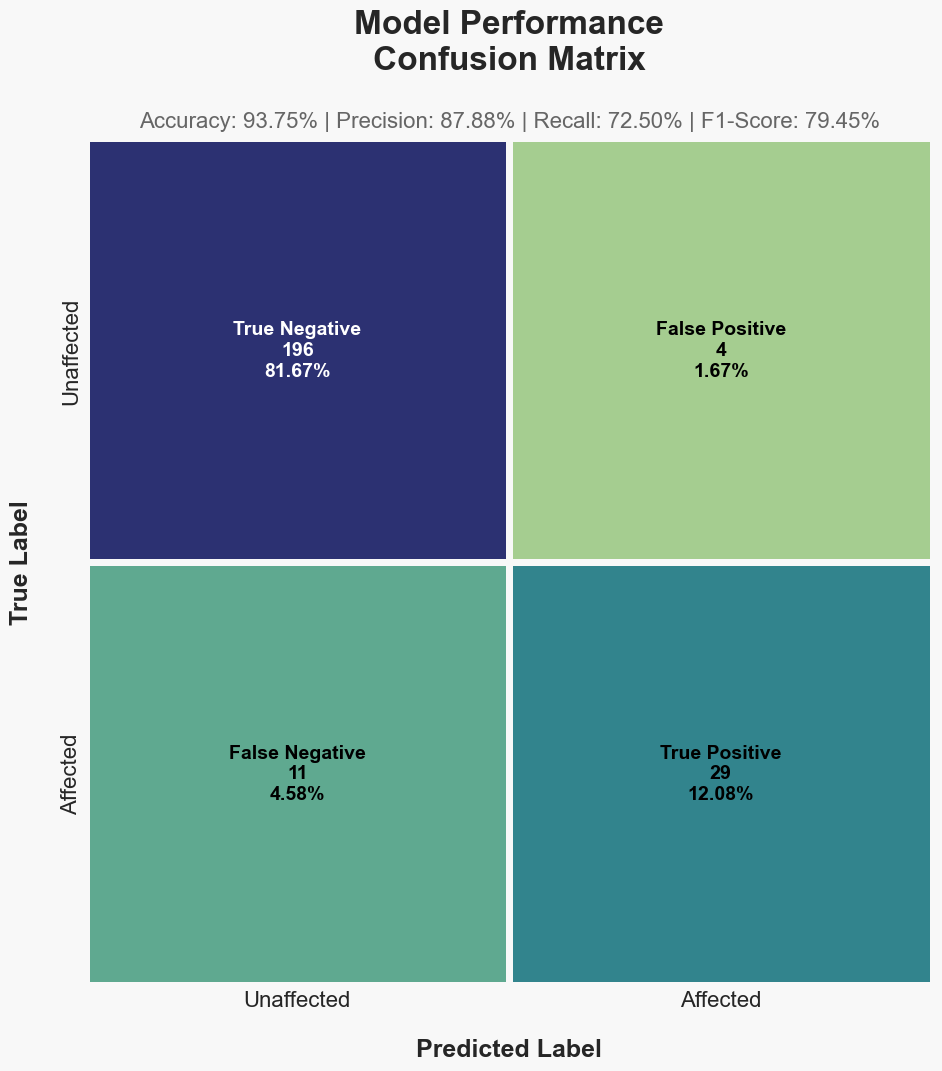

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

def plot_confusion_matrix(tp, tn, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    confusion_matrix = np.array([[tn, fp], [fn, tp]])
    
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = [f"{value:,}" for value in confusion_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value/np.sum(confusion_matrix)) for value in confusion_matrix.flatten()]
    
    box_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(2, 2)

    sns.set_style("white")
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Arial'

    fig, ax = plt.subplots(figsize=(11, 11))
    fig.set_facecolor('#F8F8F8')

    cmap = sns.color_palette("crest", as_cmap=True)

    sns.heatmap(confusion_matrix,
                annot=False,
                fmt='',
                cmap=cmap,
                cbar=False,
                linewidths=5,
                linecolor=fig.get_facecolor(),
                square=True,
                ax=ax,
                norm=LogNorm()) 
    threshold = (confusion_matrix.max() + confusion_matrix.min()) / 2.5 
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            color = "white" if confusion_matrix[i, j] > threshold else "black"
            ax.text(j + 0.5, i + 0.5, box_labels[i, j],
                    ha="center", va="center",
                    color=color, fontsize=14, weight='bold')


    title = 'Model Performance\nConfusion Matrix'
    subtitle = (f'Accuracy: {accuracy:.2%} | Precision: {precision:.2%} | '
                f'Recall: {recall:.2%} | F1-Score: {f1_score:.2%}')
    
    ax.set_title(title, fontsize=24, fontweight='bold', pad=50, loc='center')
    ax.text(0.5, 1.02, subtitle, ha='center', va='center', 
            transform=ax.transAxes, fontsize=16, color='#666666')

    ax.set_ylabel('True Label', fontsize=18, fontweight='bold', labelpad=20)
    ax.set_xlabel('Predicted Label', fontsize=18, fontweight='bold', labelpad=20)
    ax.set_xticklabels(['Unaffected', 'Affected'], fontsize=16)
    ax.set_yticklabels(['Unaffected', 'Affected'], fontsize=16, rotation=90, va='center')
    ax.tick_params(length=0)

    plt.show()

if __name__ == "__main__":
    true_positives = 29
    true_negatives = 196
    false_positives = 4
    false_negatives = 11
    
    plot_confusion_matrix(true_positives, true_negatives, false_positives, false_negatives)
